#                                              **MELANOMA DETECTION ASSIGNMENT**

AIM - To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

To build a multiclass classification model using a custom convolutional neural network in TensorFlow, the Assignment is divided into following steps :-
- 1. Data Reading & Understanding
- 2. Data Creation
- 3. Data Visualization
- 4. Model Building & Training
- 5. Augmentation to resolve underfitting or overfitting
- 6. Class Distribution
- 7. Handling Class Imbalance
- 8. Model building, training and compilation
- 9. Inferences


1. **Data** **Reading** **&** **Understanding**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
## using the data from drive by mounting the google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images in the drive

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Test")


In [ ]:
## lets check the names of all sub directories present in train and test data directories
print("Train directory contents:", os.listdir(data_dir_train))
print("Test directory contents:", os.listdir(data_dir_test))

Train directory contents: ['dermatofibroma', 'pigmented benign keratosis', 'seborrheic keratosis', 'actinic keratosis', 'squamous cell carcinoma', 'melanoma', 'vascular lesion', 'nevus', 'basal cell carcinoma']
Test directory contents: ['vascular lesion', 'squamous cell carcinoma', 'melanoma', 'seborrheic keratosis', 'basal cell carcinoma', 'pigmented benign keratosis', 'actinic keratosis', 'dermatofibroma', 'nevus']


In [ ]:
!ls

gdrive	sample_data


In [ ]:
#Lets check the total number of images present in both train and test directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


2. **Dataset Creation**

In [ ]:
# Creating Dataset by dividing Train data into train and validation sets, with batch size of 32
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#Lets check, number of files to be used for train set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Lets check, number of files to be used for validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
#Lets confirm the dtype of train set
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


**3. Dataset Visualization**

In [ ]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


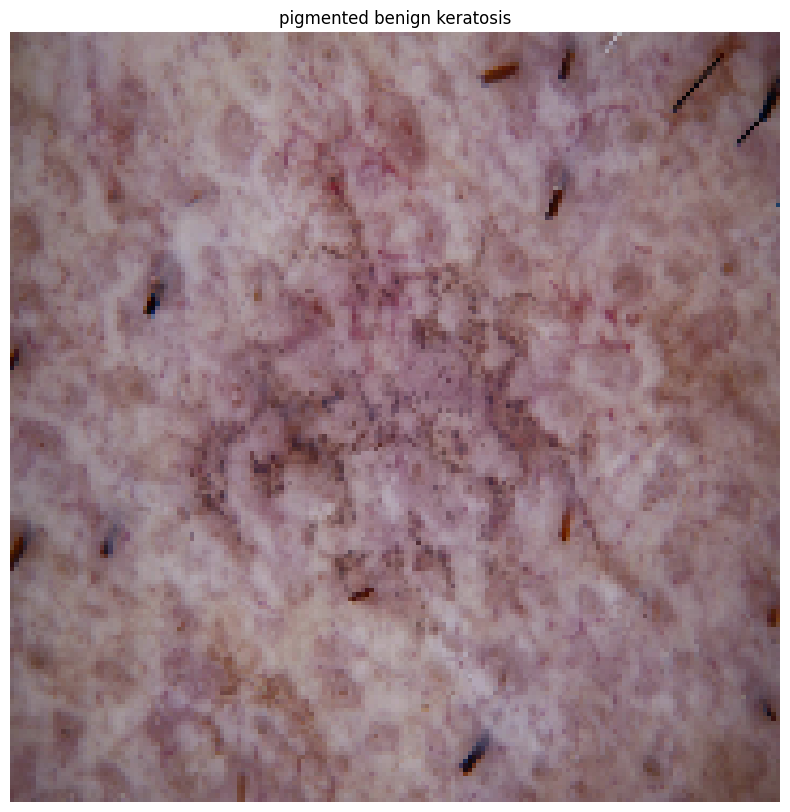

In [ ]:
#lets confirm the size of an image and have a look at image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


DATA VISUALIZATION

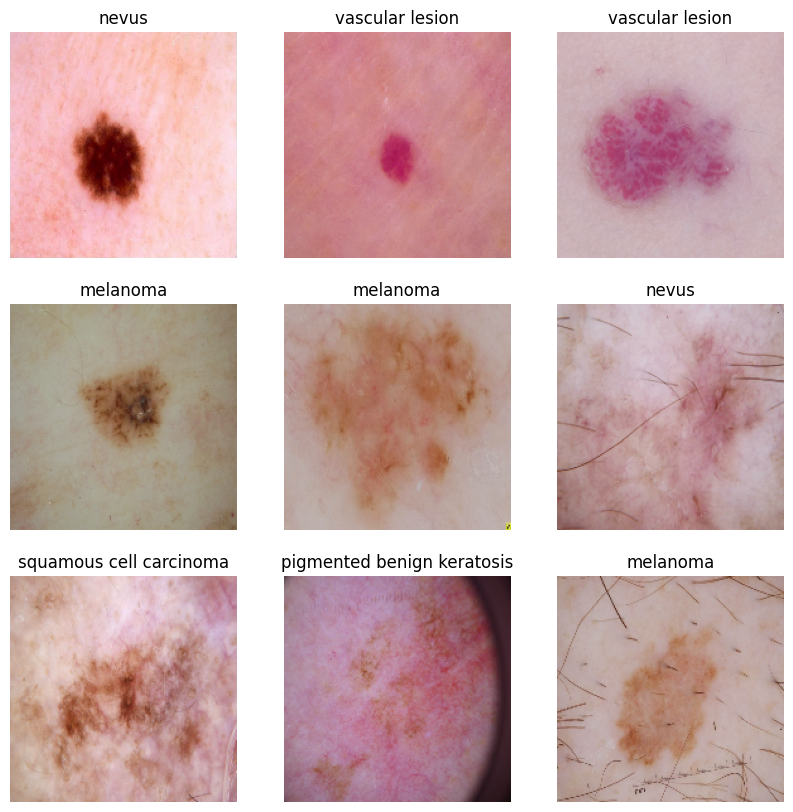

In [ ]:
# Now visualize the image of each kind of category inside train
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(type(train_ds))
print(len(train_ds))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56


**4. Model Building, Training & Compilation**

In [ ]:
#Lets tune the parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Lets build our first Model

#number of categories
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu')
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Our second step is to Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Final step s to Train Model
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 163s 661ms/step - loss: 2.0776 - accuracy: 0.2556 - val_loss: 1.8192 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7532 - accuracy: 0.3677 - val_loss: 1.7814 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5111 - accuracy: 0.4771 - val_loss: 1.4317 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3562 - accuracy: 0.5285 - val_loss: 1.4052 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2465 - accuracy: 0.5670 - val_loss: 1.3317 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1791 - accuracy: 0.5765 - val_loss: 1.3404 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1296 - accuracy: 0.6049 - val_loss: 1.3811 - val_accuracy: 0.5190
Epoch 8/20

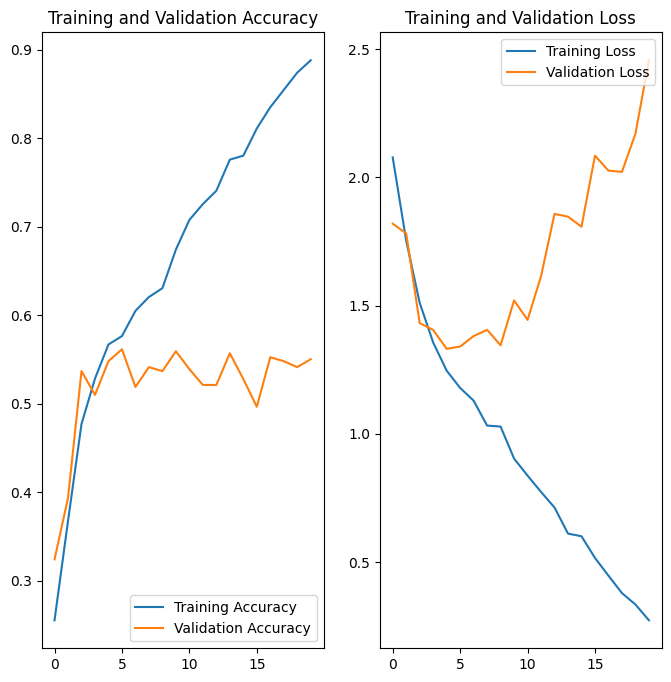

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

in the above plot we can see the issue of Overfitting, so lets build our Model for second time by adding more layers and using dropout and then Recheck

In [ ]:
# Building our second Model
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

In [ ]:
# after analysing the model fit history for presence of underfit or overfit, we choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

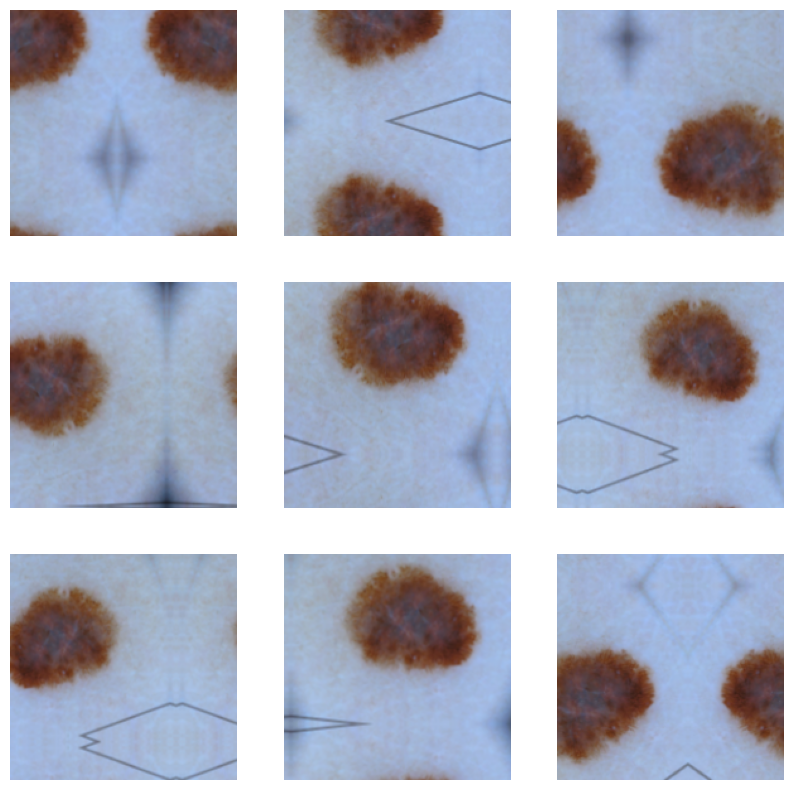

In [ ]:
 #Lets visualize how our augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
## Now we use Dropout layer here as there is an evidence of overfitting in our findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
## Lets compile the model again
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## Training the Model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 143ms/step - loss: 2.2008 - accuracy: 0.1959 - val_loss: 2.0566 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 7s 119ms/step - loss: 1.8786 - accuracy: 0.2891 - val_loss: 1.7758 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 1.6992 - accuracy: 0.3571 - val_loss: 1.6239 - val_accuracy: 0.3736
Epoch 4/20
56/56 [==============================] - 7s 125ms/step - loss: 1.6728 - accuracy: 0.3661 - val_loss: 1.7383 - val_accuracy: 0.3602
Epoch 5/20
56/56 [==============================] - 7s 123ms/step - loss: 1.6878 - accuracy: 0.3588 - val_loss: 1.6322 - val_accuracy: 0.3579
Epoch 6/20
56/56 [==============================] - 7s 126ms/step - loss: 1.6574 - accuracy: 0.3856 - val_loss: 1.7099 - val_accuracy: 0.3579
Epoch 7/20
56/56 [==============================] - 7s 123ms/step - loss: 1.6190 - accuracy: 0.3856 - val_loss: 1.6345 - val_accuracy: 0.3714
Epoch

VISUALIZING RESULTS

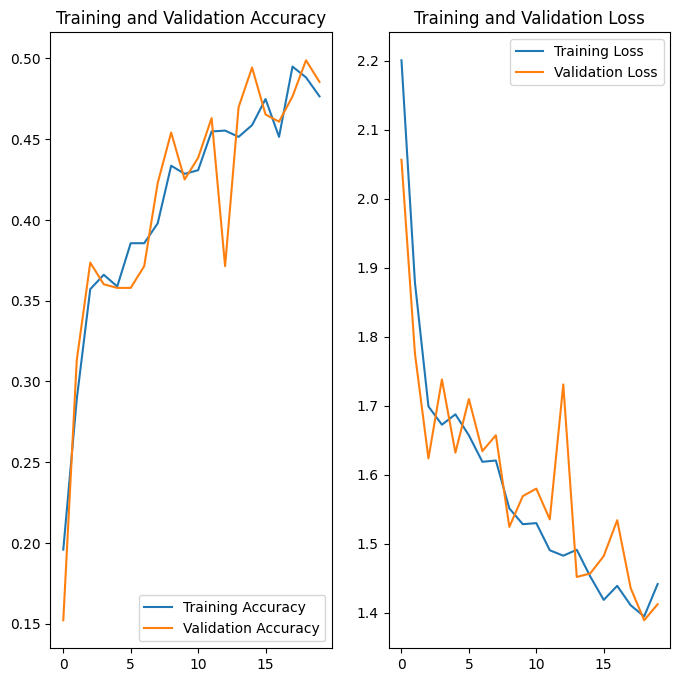

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Again, we see in the above plots, that the issue of overfitting is not resolved yet and hence we will proceed further our model by generating images and sequentially building steps

In [ ]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# Lets create our Sequential Model again

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2239 images belonging to 9 classes.


In [ ]:
# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 118 images belonging to 9 classes.


In [ ]:
# Experiment 1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(9))


# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



# Training the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 102s 4s/step - loss: 2.7721 - accuracy: 0.1871 - val_loss: 2.2698 - val_accuracy: 0.1186
Epoch 2/10
23/23 [==============================] - 58s 3s/step - loss: 1.9486 - accuracy: 0.2863 - val_loss: 2.4079 - val_accuracy: 0.2034
Epoch 3/10
23/23 [==============================] - 63s 3s/step - loss: 1.7509 - accuracy: 0.3761 - val_loss: 2.2638 - val_accuracy: 0.2373
Epoch 4/10
23/23 [==============================] - 67s 3s/step - loss: 1.6022 - accuracy: 0.4265 - val_loss: 2.2722 - val_accuracy: 0.2966
Epoch 5/10
23/23 [==============================] - 56s 2s/step - loss: 1.4916 - accuracy: 0.4819 - val_loss: 2.0598 - val_accuracy: 0.3559
Epoch 6/10
23/23 [==============================] - 56s 2s/step - loss: 1.4288 - accuracy: 0.4926 - val_loss: 2.1679 - val_accuracy: 0.3390
Epoch 7/10
23/23 [==============================] - 55s 2s/step - loss: 1.3981 - accuracy: 0.5074 - val_loss: 2.2704 - val_accuracy: 0.3220
Epoch 8/10
23/23 [=

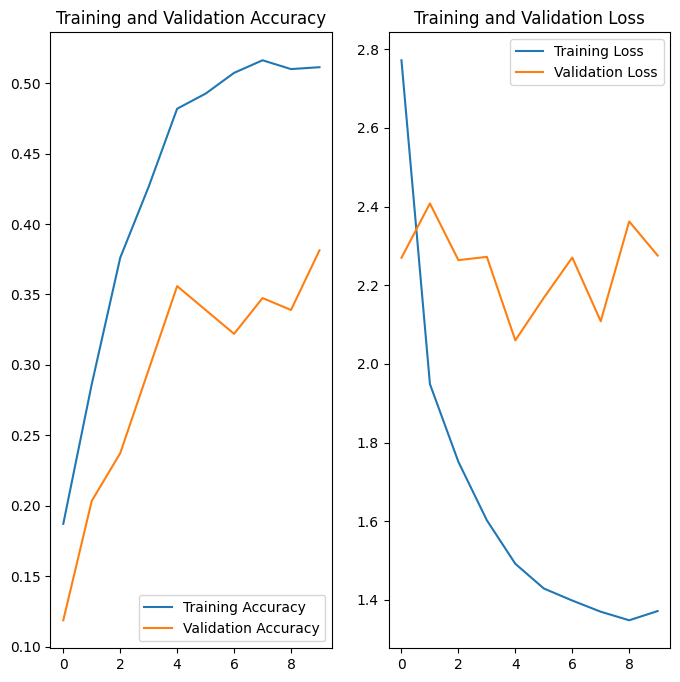

In [ ]:
# Visualizing the Model
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the above plots, we can see overfitting is reduced but not as required, so lets move to our final strategy, i.e Data Augmentation to reduce Overfitting issue

**5. CLASS DISTRIBUTION**

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,dermatofibroma
1,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,dermatofibroma
2,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,dermatofibroma
3,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,dermatofibroma
4,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,dermatofibroma
...,...,...
2234,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,basal cell carcinoma
2235,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,basal cell carcinoma
2236,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,basal cell carcinoma
2237,/content/gdrive/MyDrive/Skin Cancer ISIC The I...,basal cell carcinoma


Class=2, n=95 (4.243%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)


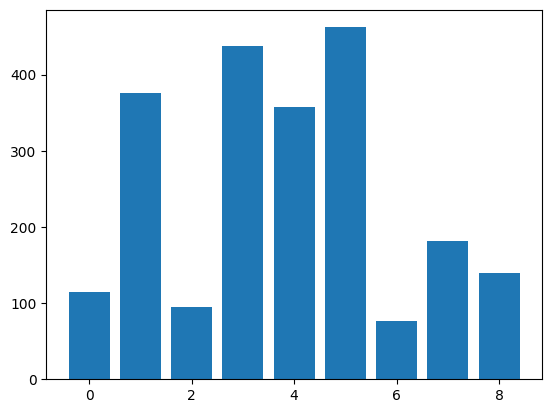

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

**6. DATA AUGMENTATION**

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
print(Augmentor.__version__)

0.2.12


In [ ]:
pip install --upgrade Augmentor

In [ ]:
datapath = r'/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(150)
p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B24F4353400>: 100%|██████████| 150/150 [00:06<00:00, 21.46 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B24F433D7B0>: 100%|██████████| 114/114 [00:04<00:00, 26.77 Samples/s]


In [ ]:
#lets initiate a pipeline to point the directory which contain initial image dataset
path_to_training_dataset="/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B250858BB50>: 100%|██████████| 500/500 [00:19<00:00, 25.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B257C581600>: 100%|██████████| 500/500 [00:17<00:00, 27.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B24F4254400>: 100%|██████████| 500/500 [00:17<00:00, 28.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B24F433F0D0>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B250858B100>: 100%|██████████| 500/500 [01:23<00:00,  6.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B24F4351090>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B24F4222B90>: 100%|██████████| 500/500 [00:43<00:00, 11.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B250858A680>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B258DEDE230>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


In [ ]:
#Now lets take a look at total count of images which are augmented
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4764


In [ ]:
#Lets see the distribution of augmented data after adding new images to the original training data.
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_e67cf293-ca85-4523-af45-f8698ffd893c.jpg',
 '/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028926.jpg_b3c9cc89-b1de-43d8-9946-422ae2e88b01.jpg',
 '/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_20319d84-70c2-43f9-b96b-2f34fc45fac9.jpg',
 '/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_f66ce536-a8b6-4989-8659-42e45957ca2f.jpg',
 '/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030015.jpg_e8e4dfca-f0de-4ca9-a821-913b86a83a24.jpg',


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
#Lets create new dataframe with new added images
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-51-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
#Lets count total number of images we have after adding new images
new_df['Label'].value_counts()

pigmented benign keratosis    962
actinic keratosis             853
dermatofibroma                595
seborrheic keratosis          577
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
Name: Label, dtype: int64

**7. MODEL BUILDING, COMPILING & TRAINING AFTER AUGMENTATION**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# split data into train and validation sets
data_dir_train="/content/gdrive/MyDrive/Skin Cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7003 files belonging to 9 classes.
Using 5603 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7003 files belonging to 9 classes.
Using 1400 files for validation.


In [ ]:
# Lets create our model using batch Normalization
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
## compiling the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## Training our model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
176/176 [==============================] - 35s 61ms/step - loss: 2.0657 - accuracy: 0.2115 - val_loss: 1.7005 - val_accuracy: 0.3779
Epoch 2/20
176/176 [==============================] - 5s 27ms/step - loss: 1.5581 - accuracy: 0.4103 - val_loss: 1.3647 - val_accuracy: 0.4650
Epoch 3/20
176/176 [==============================] - 5s 29ms/step - loss: 1.3966 - accuracy: 0.4837 - val_loss: 1.3070 - val_accuracy: 0.5229
Epoch 4/20
176/176 [==============================] - 5s 27ms/step - loss: 1.2351 - accuracy: 0.5426 - val_loss: 1.4353 - val_accuracy: 0.4529
Epoch 5/20
176/176 [==============================] - 5s 27ms/step - loss: 1.0934 - accuracy: 0.6007 - val_loss: 1.1612 - val_accuracy: 0.5643
Epoch 6/20
176/176 [==============================] - 5s 29ms/step - loss: 0.9127 - accuracy: 0.6700 - val_loss: 0.9629 - val_accuracy: 0.6657
Epoch 7/20
176/176 [==============================] - 5s 27ms/step - loss: 0.8064 - accuracy: 0.7059 - val_loss: 0.9433 - val_accuracy: 0.675

**8. VISUALIZATION OF NEW MODEL**

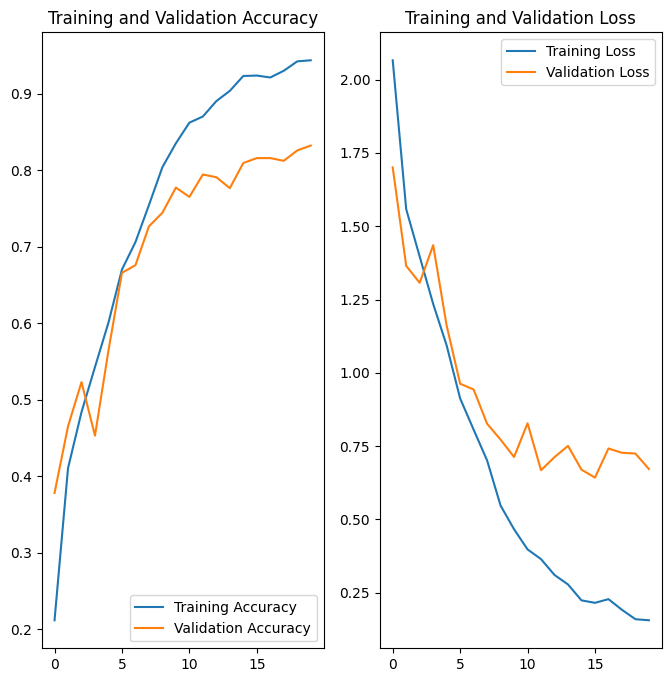

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**9. INFERENCES**

- In the above graph, we can see that we have reduced the difference between train and validation images accuracy and loss, i.e the issue of overfitting is not reduced completely but upto some extent.
- Also, we can see that both the training and validation sets have good and almost nearby values of their accuracies, which is good achievement